In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd
import math
import pycolmap


# plt.rcParams.update({'font.size': 16})


In [2]:
def getAUC(errors, threshold_list):
    auc = []

    for threshold in threshold_list:
        auc.append(np.sum(errors < threshold)/len(errors))

    return auc

In [3]:
def plotCDF_all(results, method_names, skip_name = []):
    method_names_ = method_names.copy()
    error_names = ['R Error (deg)', 't Error (cm)', 'f Error (%)', 'Runtime (ms)', 'Iterations', 'Num Inliers']
    error_limits = [50, 50, 200, 1000]
    n = len(method_names)

    plt.figure(figsize=(10, 6))
    for i in range(len(error_names)):
        plt.subplot(2, 3, i+1)
        for j in range(n):
            if method_names[j] in skip_name:
                continue
            sns.ecdfplot(results[:,i+j*6])
        plt.xlabel(error_names[i])
        plt.ylabel('CDF')

    for name_ in method_names:
        if name_ in skip_name:
            method_names_.remove(name_)

    plt.legend(method_names_)
    plt.tight_layout()
    plt.show()



In [4]:
def collectErrors(errors, method_names):
    assert len(errors[list(errors.keys())[0]]) == len(method_names)*6

    results = []
    for query_name in errors.keys():
        results.append(errors[query_name])
    results = np.array(results)

    return results

In [5]:
def showErrors(errors, method_names):
    
    top_level_headers = ['R Error (deg)', 't Error (cm)', 'f Error (%)', 'Runtime (ms)', 'Iterations', 'Num Inliers']

    table = np.reshape(errors, (len(method_names), 6))
    df = pd.DataFrame(table, columns=top_level_headers, index=method_names)

    return df

In [6]:
def getAUC(errors, R_idx, t_idx, R_thrs, t_thrs):
    n = errors.shape[0]
    assert len(R_thrs) == len(t_thrs)
    
    auc = []
    for j in range(len(R_thrs)):
        auc_ = 0
        for i in range(n):
            if errors[i,R_idx] < R_thrs[j] and errors[i,t_idx] < t_thrs[j]:
                auc_ += 1
        auc.append(auc_/n)
    return auc

# Dataset statistics

In [20]:
scene_list = ["festia_out_corridor", "sportunifront", "parakennus_out", "main_campus", "Kitchen_In"]
#, "meetingroom", "night_out", "outcorridor", "parakennus", "upstairs"
# larger sequence 0, 1, 3, 9
scene = scene_list[2]
gt_dirs = Path("/home2/xi5511zh/Xinyue/Datasets/Fisheye_FIORD")
# method_names = ['p3p', 'P4Pfr_LM', 'P4Pfr_HC_pose', 'P4Pfr_HC_depth', 'P3P_sampling_LM', 'P3P_sampling_HC']
method_names = ['p3p', 'P4Pfr', 'P4Pfr_LM', 'P4Pfr_HC_pose', 'P4Pfr_HC_depth', 'P3P_sampling_LM', 'P3P_sampling_HC', 'P5Pfr', 'P5Pfr_LM']

In [21]:
# import gc
# dataset_stats = []

# for scene in scene_list:
#     gt_sfm = gt_dirs / scene / "colmap/model"
#     gt_sfm = pycolmap.Reconstruction(gt_sfm)
#     nTotal = len(gt_sfm.images)

#     ref_sfm = gt_dirs / scene / "processed_remove_neighbours/colmap"
#     ref_sfm = pycolmap.Reconstruction(ref_sfm)
#     nDatabase = len(ref_sfm.images)

#     query_results = gt_dirs / scene / "processed_remove_neighbours/hloc/RANSACresults_remove_neighbours.pkl"
#     with open(query_results, 'rb') as f:
#         query_results = pickle.load(f)
#     nQuery = len(list(query_results.keys()))

#     dataset_stats.append({"scene": scene, "nTotal": nTotal, "nDatabase": nDatabase, "nQuery": nQuery})
    
#     del gt_sfm, ref_sfm

#     gc.collect()

# dataset_stats = pd.DataFrame(dataset_stats)
# dataset_stats


# load results

In [44]:
map_prefix = "covisible30"

In [45]:
results_all = {}
results_overall = []
for scene in scene_list:
    results_dir = gt_dirs / scene / f"processed_{map_prefix}/hloc/RANSACresults_{map_prefix}.pkl"
    with open(results_dir, 'rb') as f:
        errors = pickle.load(f)
    results = collectErrors(errors, method_names)
    results_all[scene] = results
    results_overall.append(results)
results_overall = np.concatenate(results_overall, axis=0)

In [46]:
medianError = np.median(results_overall, axis=0)
df_median = showErrors(medianError, method_names)
display(df_median.style.format('{:.4f}'))

,R Error (deg),t Error (cm),f Error (%),Runtime (ms),Iterations,Num Inliers
p3p,1.2271,16.4851,0.0000,10.1230,101.0000,2114.0000
P4Pfr,0.0528,0.4648,0.8862,172.0643,256.5000,1164.5000
P4Pfr_LM,0.0525,0.4651,0.9094,53.3792,256.5000,1164.5000
P4Pfr_HC_pose,0.0514,0.4572,0.8622,97.1122,256.5000,1164.5000
P4Pfr_HC_depth,0.0533,0.4865,0.8790,86.6811,256.0000,1165.0000
P3P_sampling_LM,0.0517,0.4819,0.9094,70.5686,256.5000,1165.0000
P3P_sampling_HC,0.0528,0.4619,0.8870,170.3283,256.5000,1164.5000
P5Pfr,0.0531,0.4761,0.9313,142.0359,462.0000,1164.5000
P5Pfr_LM,0.0517,0.4774,0.9169,49.8517,463.5000,1164.5000


In [47]:
meanError = np.mean(results_overall, axis=0)
df_mean = showErrors(meanError, method_names)
display(df_mean.style.format('{:.4f}'))

,R Error (deg),t Error (cm),f Error (%),Runtime (ms),Iterations,Num Inliers
p3p,8.1750,95.6805,0.0000,11.3384,101.0000,2048.9789
P4Pfr,0.1099,1.3754,2.2580,239.7792,462.4316,1217.0368
P4Pfr_LM,0.1019,1.0363,1.9886,67.5627,463.1579,1216.9105
P4Pfr_HC_pose,0.1159,1.3695,2.1116,130.1055,462.9421,1216.7947
P4Pfr_HC_depth,0.1097,1.5537,6.5108,107.5702,463.9368,1216.8895
P3P_sampling_LM,0.1192,1.3344,2.2181,94.1227,463.4789,1216.8368
P3P_sampling_HC,0.1159,1.3688,2.1203,277.4787,462.8789,1216.8895
P5Pfr,0.1254,2.3208,9.1815,199.1714,763.6737,1216.8053
P5Pfr_LM,0.2108,2.2052,1.8520,56.9763,763.2105,1217.0526


## AUC (R and t)

In [48]:
R_thr = [1, 1, 2, 5, 5]
t_thr = [1, 2, 5, 5, 10]
f_thr = [1, 2, 5, 10, 50]

AUC = []
for m_idx in range(len(method_names)):
    auc_ = getAUC(results_overall, m_idx*6, m_idx*6+1, R_thr, t_thr)
    AUC.append({'method': method_names[m_idx], f"{R_thr[0]}deg, {t_thr[0]}cm": f"{auc_[0]*100:.2f}", 
        f"{R_thr[1]}deg, {t_thr[1]}cm": f"{auc_[1]*100:.2f}", f"{R_thr[2]}deg, {t_thr[2]}cm": f"{auc_[2]*100:.2f}",
        f"{R_thr[3]}deg, {t_thr[3]}cm": f"{auc_[3]*100:.2f}", f"{R_thr[4]}deg, {t_thr[4]}cm": f"{auc_[4]*100:.2f}", 
        "mean time (ms)": f"{np.mean(results_overall, axis=0)[m_idx*6+3]:.2f}"})
AUC = pd.DataFrame(AUC)
display(AUC)

,method,"1deg, 1cm","1deg, 2cm","2deg, 5cm","5deg, 5cm","5deg, 10cm",mean time (ms)
0,p3p,4.21,9.47,27.37,27.89,38.42,11.34
1,P4Pfr,75.26,88.95,96.32,96.32,97.89,239.78
2,P4Pfr_LM,74.74,90.00,96.84,96.84,98.42,67.56
3,P4Pfr_HC_pose,74.74,90.53,96.84,96.84,97.89,130.11
4,P4Pfr_HC_depth,74.74,90.53,96.84,96.84,97.89,107.57
5,P3P_sampling_LM,74.74,90.53,96.32,96.32,98.42,94.12
6,P3P_sampling_HC,74.21,90.00,96.84,96.84,98.42,277.48
7,P5Pfr,74.21,90.53,96.84,96.84,97.89,199.17
8,P5Pfr_LM,75.26,90.00,96.32,96.32,98.42,56.98


## AUC (t and f)

In [49]:
AUC = []
for m_idx in range(len(method_names)):
    auc_ = getAUC(results_overall, m_idx*6+1, m_idx*6+2, t_thr, f_thr)
    AUC.append({'method': method_names[m_idx], f"{R_thr[0]}cm, {t_thr[0]}px": f"{auc_[0]*100:.2f}", 
        f"{R_thr[1]}cm, {t_thr[1]}px": f"{auc_[1]*100:.2f}", f"{R_thr[2]}cm, {t_thr[2]}px": f"{auc_[2]*100:.2f}",   
        f"{R_thr[3]}cm, {t_thr[3]}px": f"{auc_[3]*100:.2f}", f"{R_thr[4]}cm, {t_thr[4]}px": f"{auc_[4]*100:.2f}", 
        "mean time (ms)": f"{np.mean(results_overall, axis=0)[m_idx*6+3]:.2f}"})
AUC = pd.DataFrame(AUC)
display(AUC)

,method,"1cm, 1px","1cm, 2px","2cm, 5px","5cm, 5px","5cm, 10px",mean time (ms)
0,p3p,4.21,9.47,27.89,27.89,38.42,11.34
1,P4Pfr,51.05,72.63,93.16,95.79,97.89,239.78
2,P4Pfr_LM,50.00,71.58,93.68,96.32,98.42,67.56
3,P4Pfr_HC_pose,50.53,73.16,93.16,96.84,97.89,130.11
4,P4Pfr_HC_depth,50.00,72.63,94.21,96.84,97.89,107.57
5,P3P_sampling_LM,49.47,71.58,93.68,96.32,98.42,94.12
6,P3P_sampling_HC,50.53,72.11,93.16,96.84,98.42,277.48
7,P5Pfr,50.00,71.58,94.21,96.84,97.89,199.17
8,P5Pfr_LM,50.00,71.58,93.16,95.79,98.42,56.98


## Median Table

In [50]:
for scene in scene_list:
    results = results_all[scene]
    display(scene)
    medianError = np.median(results, axis=0)
    df_median = showErrors(medianError, method_names)
    display(df_median)

'festia_out_corridor'

,R Error (deg),t Error (cm),f Error (%),Runtime (ms),Iterations,Num Inliers
p3p,0.462551,4.544808,0.000000,12.892647,101.0,2676.5
P4Pfr,0.072654,0.389542,0.910576,148.573562,152.5,1651.0
P4Pfr_LM,0.071389,0.400443,0.893712,51.748011,151.5,1651.0
P4Pfr_HC_pose,0.071453,0.394259,0.893712,81.090699,151.5,1651.0
P4Pfr_HC_depth,0.072608,0.400443,0.844778,74.237289,152.5,1650.5
P3P_sampling_LM,0.071389,0.400443,0.961134,66.937984,151.5,1651.0
P3P_sampling_HC,0.072362,0.399015,0.886242,124.600733,151.5,1651.0
P5Pfr,0.072748,0.400443,0.888690,125.376545,246.5,1651.0
P5Pfr_LM,0.072362,0.400443,0.893712,49.903450,245.5,1651.0


'sportunifront'

,R Error (deg),t Error (cm),f Error (%),Runtime (ms),Iterations,Num Inliers
p3p,15.626857,111.074444,0.000000,5.934422,101.0,893.5
P4Pfr,0.062828,0.953930,1.793335,175.864905,522.5,475.0
P4Pfr_LM,0.062828,1.004032,2.012962,56.019897,522.5,475.0
P4Pfr_HC_pose,0.062330,0.976403,1.793335,128.174737,522.5,475.0
P4Pfr_HC_depth,0.062828,0.979136,1.787886,102.621715,522.5,475.5
P3P_sampling_LM,0.062200,0.998664,2.181538,70.250557,522.5,475.0
P3P_sampling_HC,0.062330,1.001299,1.939948,284.390020,522.5,475.0
P5Pfr,0.062267,1.004810,1.939948,122.093996,1109.0,475.0
P5Pfr_LM,0.062828,0.979136,2.097739,35.265593,1093.0,475.0


'parakennus_out'

,R Error (deg),t Error (cm),f Error (%),Runtime (ms),Iterations,Num Inliers
p3p,2.525324,34.802613,0.000000,10.451071,101.0,2226.5
P4Pfr,0.180030,1.559924,1.645662,665.436895,1179.5,868.5
P4Pfr_LM,0.176147,1.612504,1.647848,155.398835,1256.5,872.5
P4Pfr_HC_pose,0.166257,1.498999,1.753715,326.314355,1209.0,869.5
P4Pfr_HC_depth,0.189718,1.618409,1.738614,282.990004,1324.0,865.5
P3P_sampling_LM,0.158434,1.480794,1.801850,239.254868,1275.0,873.0
P3P_sampling_HC,0.182774,1.607278,1.753715,728.781273,1199.0,870.0
P5Pfr,0.182774,1.613655,1.886667,475.231104,2000.0,865.5
P5Pfr_LM,0.176990,1.655951,1.766051,86.359644,2000.0,873.5


'main_campus'

,R Error (deg),t Error (cm),f Error (%),Runtime (ms),Iterations,Num Inliers
p3p,0.700370,6.089355,0.000000,12.555926,101.0,2416.5
P4Pfr,0.024176,0.127122,0.268591,159.057581,182.5,1533.0
P4Pfr_LM,0.023906,0.127925,0.267115,49.022149,183.0,1532.5
P4Pfr_HC_pose,0.023906,0.127638,0.264837,81.157956,183.0,1533.0
P4Pfr_HC_depth,0.023906,0.125486,0.267115,69.936633,183.0,1532.5
P3P_sampling_LM,0.023906,0.125486,0.267115,65.665106,183.0,1532.5
P3P_sampling_HC,0.023906,0.126477,0.268591,136.375095,183.0,1533.0
P5Pfr,0.023906,0.127925,0.268006,131.014887,305.5,1533.0
P5Pfr_LM,0.023906,0.129425,0.267413,44.787985,305.5,1533.0


'Kitchen_In'

,R Error (deg),t Error (cm),f Error (%),Runtime (ms),Iterations,Num Inliers
p3p,1.974614,33.275896,0.000000,7.369256,101.0,1353.5
P4Pfr,0.054847,0.754526,1.803138,166.959268,450.5,655.5
P4Pfr_LM,0.054900,0.754526,1.803138,52.708204,450.5,655.5
P4Pfr_HC_pose,0.054847,0.754526,1.803138,124.403360,450.5,655.5
P4Pfr_HC_depth,0.057063,0.756355,1.803138,97.203889,450.5,655.5
P3P_sampling_LM,0.053475,0.754526,1.792893,70.553008,450.5,655.5
P3P_sampling_HC,0.054847,0.754526,1.803138,235.423395,450.5,655.5
P5Pfr,0.054847,0.754526,1.803138,151.044999,924.5,655.5
P5Pfr_LM,0.054847,0.754526,1.803138,51.666552,924.5,655.5


## Mean Table

In [51]:
# for scene in scene_list:
#     results = results_all[scene]

#     display(scene)
#     meanError = np.mean(results, axis=0)
#     df_mean = showErrors(meanError, method_names)
#     display(df_mean)

# Error CDF

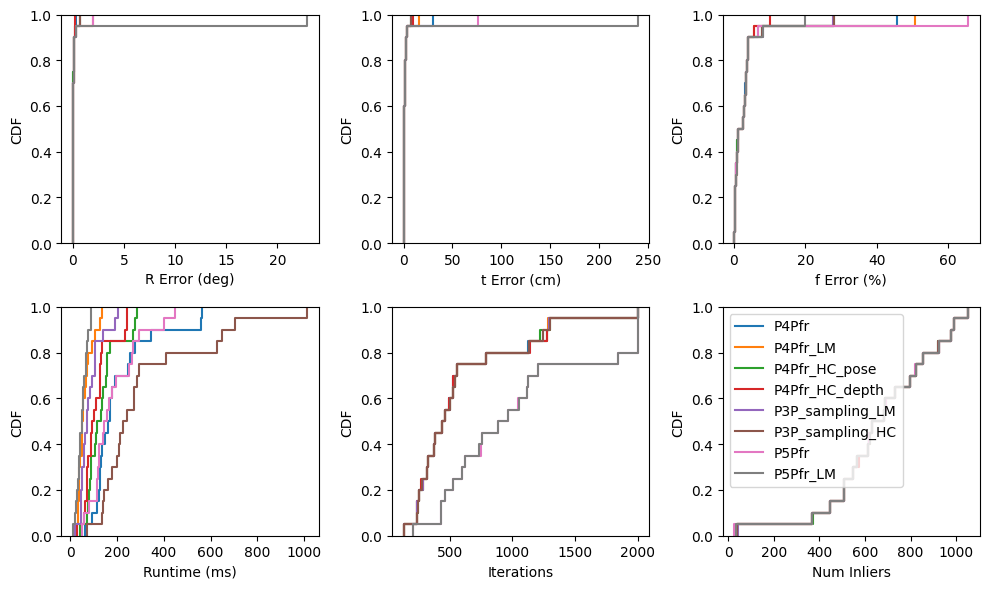

In [52]:
plotCDF_all(results, method_names, 'p3p')

# check individual error

In [53]:
query_name_list = list(errors.keys())
query_name = query_name_list[16]

In [54]:
corrs = gt_dirs / scene / "processed_remove_neighbours/Corrs/CorrsDict.pkl"
with open(corrs, 'rb') as f:
    corrs = pickle.load(f)
corrs[query_name]['imageID']


KeyError: 'cam1/IMG_20241125_221221_00_146_fisheye1.jpg'

In [ ]:
query_name = 'cam1/IMG_20250330_115955_00_235_fisheye1.jpg'

In [ ]:
df = showErrors(errors[query_name], method_names)
df

KeyError: 'cam1/IMG_20250330_115955_00_235_fisheye1.jpg'